### Проект 4. Компьютер говорит нет ¶
#### Исполнитель: Богданова Юлия
#### Группа: SF-DST-34

![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Credit Scoring
## Прогнозирование вероятности дефолта заемщика

Предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

## 0. Импорт библиотек

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime, date, time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

## 1. Импорт данных

In [4]:
df_train = pd.read_csv("./train.csv/train.csv")
df_test = pd.read_csv("./test.csv/test.csv")
sample_submission = pd.read_csv('./sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [8]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [9]:
sample_submission.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [11]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описание полей:

* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* foreign_passport - наличие загранпаспорта
* default - флаг дефолта по кредиту

In [13]:
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
29635,49763,26FEB2014,SCH,F,45,Y,Y,0,0,-2.307679,0,70,1,2,25000,1,3,Y,0,0
101820,43791,20FEB2014,SCH,F,27,N,N,0,0,-1.986297,3,60,2,3,27000,3,2,N,1,1
107943,104541,23APR2014,UGR,F,37,N,N,0,1,-2.303327,1,60,2,3,25000,1,4,N,1,0
40094,69154,17MAR2014,GRD,F,34,Y,Y,0,1,-2.291033,1,70,1,3,60000,1,4,N,1,1
49480,13403,21JAN2014,SCH,M,38,Y,N,0,0,-2.136227,0,60,1,2,70000,1,3,Y,1,0


Видно, что признак edication содержит пустые значения. Кроме того, имеются строковые признаки, которые требуют предобработки.

## 2. Обработка признаков

Для удобства опеределим функции.

In [14]:
# Основных сведений о признаке
def column_info(column):
    print('Количество пустых значений в столбце:', (df[column].isnull()).sum(), '\n')
    print('Процент непустых/пустых значений в столбце: \n', df[column].isnull().value_counts(normalize=True)*100, '\n')
    print('Количество уникальных значений:', df[column].nunique(), '\n')
    print('Количество вхождений каждого значения: \n', df[column].value_counts(), '\n')    
    return


# Определение выбросов
def outliers_iqr(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower = q1 - (iqr * 1.5)
    upper = q3 + (iqr * 1.5)
    return lower, upper, iqr


# Визуализация числовых признаков и выбросы
def visual_num(data, col, size=6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize=(2*size, size))
    fig.suptitle(
        'Распределение и выбросы для {0} по default'.format(col), fontsize=20)
    g1.hist(data[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8)
    g2.boxplot([data[data.default == 0][col], data[data.default == 1][col]])
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.xticks([1, 2], ["0", "1"])
    plt.show


def outliers(data, col):
    l, r, iqr = outliers_iqr(data[col])

    out = (data[col] > r).sum() + (data[col] < l).sum()
    out_percent = round(out/data[col].count()*100, 1)
    print(f'___{col}___')
    print(f'IQR: {iqr}, границы выбросов: [{l}, {r}]')
    print(f'Всего {out} ({out_percent}%) выбросов')


# Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_train', 'f1_test', 'ROC_AUC']


# Добавляем метрики в общую таблицу
def summary_metrics(summary, col, y_valid, y_pred, y_pred_probs, y_train, y_pred_train):
    values = [accuracy_score(y_valid, y_pred), precision_score(y_valid, y_pred), recall_score(
        y_valid, y_pred), f1_score(y_train, y_pred_train), f1_score(y_valid, y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary


# Кривая ROC_AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    
# Визуализация confusion matrix
def conf_mat(y_valid, y_pred):
    cm = confusion_matrix(y_valid, y_pred)

    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()

Разберемся с единственным признаком, который содержит NaN.

In [15]:
column_info('education')

Количество пустых значений в столбце: 478 

Процент непустых/пустых значений в столбце: 
 False    99.566038
True      0.433962
Name: education, dtype: float64 

Количество уникальных значений: 5 

Количество вхождений каждого значения: 
 SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64 



<AxesSubplot:>

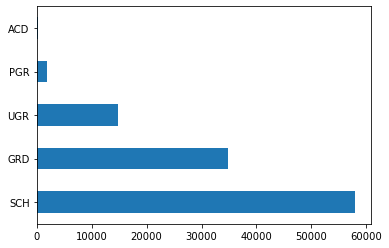

In [16]:
df['education'].value_counts().plot.barh()

In [17]:
# Учитывая, что пустых значений меньше 1 %, удалим их из датасета.
# Можно было вынести информацию о наличии пропуска как отдельный признак и заменить чем-нибудь, но их слишком мало,
# чтобы вносить неопределенность
df.dropna(inplace=True)

Необходимо определиться какие признаки являются числовыми, какие категориальными.

По шапке датафрейма видно, что age, score_bki и income являются числовыми признаками. Исследуем другие.

In [18]:
column_info('decline_app_cnt')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: decline_app_cnt, dtype: float64 

Количество уникальных значений: 24 

Количество вхождений каждого значения: 
 0     91033
1     12468
2      3617
3      1362
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64 



Этот признак, очевидно, числовой. Смотрим дальше.

In [19]:
column_info('bki_request_cnt')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: bki_request_cnt, dtype: float64 

Количество уникальных значений: 40 

Количество вхождений каждого значения: 
 0     28757
1     27174
2     20390
3     13622
4      8381
5      4945
6      2492
7      1284
8       732
9       457
10      348
11      278
12      216
13      150
14      109
15       80
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64 



In [20]:
column_info('region_rating')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: region_rating, dtype: float64 

Количество уникальных значений: 7 

Количество вхождений каждого значения: 
 50    40834
60    23917
40    17877
80    17030
70     9268
30      431
20      313
Name: region_rating, dtype: int64 



In [21]:
column_info('sna')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: sna, dtype: float64 

Количество уникальных значений: 4 

Количество вхождений каждого значения: 
 1    70341
4    17406
2    15785
3     6138
Name: sna, dtype: int64 



In [22]:
column_info('first_time')

Количество пустых значений в столбце: 0 

Процент непустых/пустых значений в столбце: 
 False    100.0
Name: first_time, dtype: float64 

Количество уникальных значений: 4 

Количество вхождений каждого значения: 
 3    46415
4    27849
1    18220
2    17186
Name: first_time, dtype: int64 



Поскольку не имеется информации о том, что конкретно означает этот признак, будем считать его категориальным. Тогда

Обработаем признак app_date.

In [23]:
# Переведем даты в формат datetime
df['app_date'] = pd.to_datetime(df['app_date'])

In [24]:
# Вычислим, как давно была подана последняя заявка, т.е. насколько свежа заявка (в днях) и добавим инфо в признак
df['app_date_freshness'] = df.app_date.apply(lambda x: (datetime.now() - x).days)

In [25]:
df = df.drop('app_date', axis=1)

Разделим признаки на группы.

In [26]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'app_date_freshness']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']


### 2.1. Числовые признаки

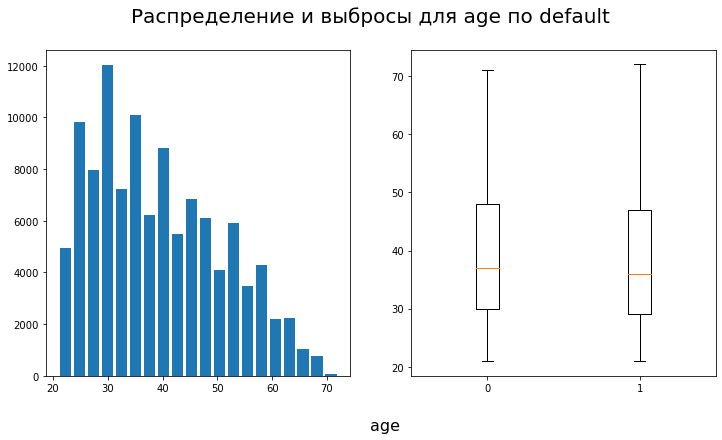

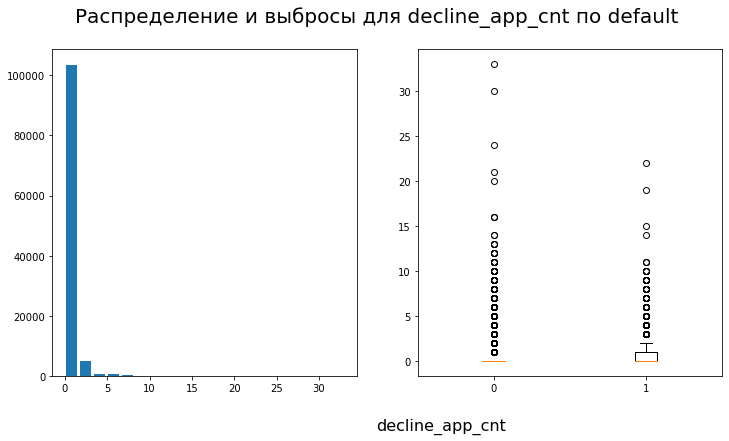

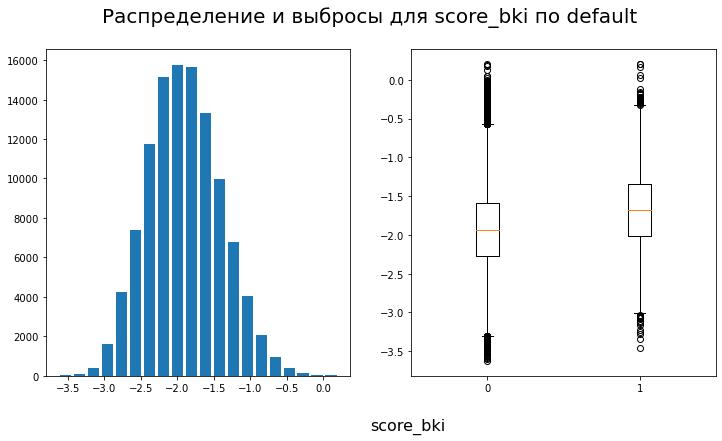

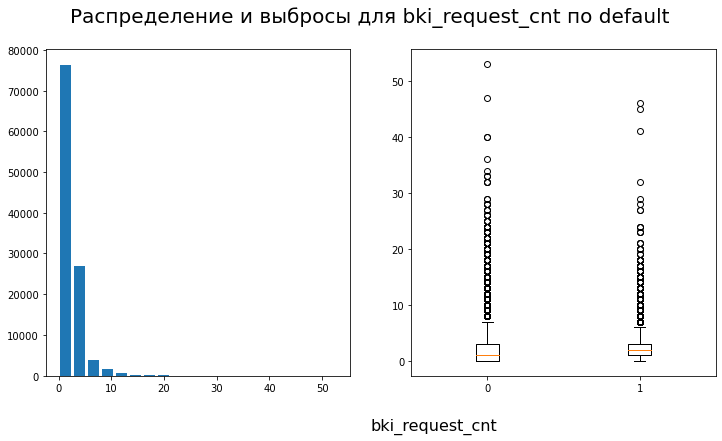

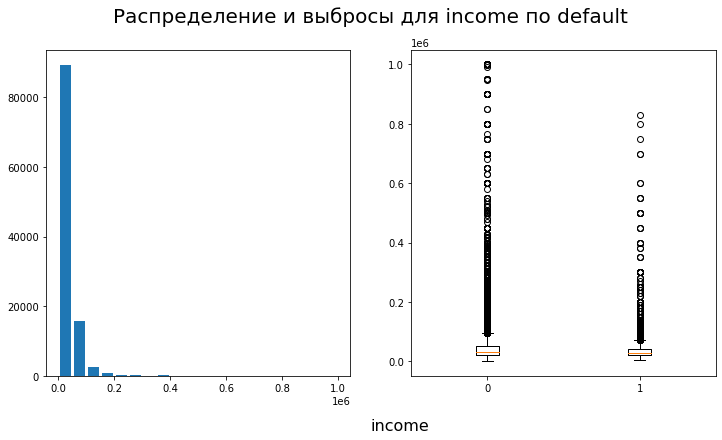

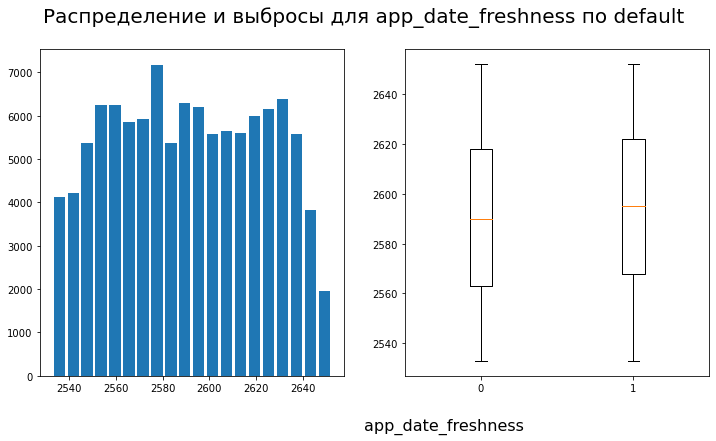

In [27]:
# Посмотрим на распределение числовых признаков
for col in num_cols:
    visual_num(df, col)

In [28]:
# Смотрим на выбросы
for col in num_cols:
    outliers(df, col)

___age___
IQR: 18.0, границы выбросов: [3.0, 75.0]
Всего 0 (0.0%) выбросов
___decline_app_cnt___
IQR: 0.0, границы выбросов: [0.0, 0.0]
Всего 18637 (17.0%) выбросов
___score_bki___
IQR: 0.6926475674999999, границы выбросов: [-3.2992846612499998, -0.5286943912500002]
Всего 515 (0.5%) выбросов
___bki_request_cnt___
IQR: 3.0, границы выбросов: [-4.5, 7.5]
Всего 2625 (2.4%) выбросов
___income___
IQR: 28000.0, границы выбросов: [-22000.0, 90000.0]
Всего 6962 (6.3%) выбросов
___app_date_freshness___
IQR: 56.0, границы выбросов: [2479.0, 2703.0]
Всего 0 (0.0%) выбросов


Выбросов в decline_app_cnt много - пока оставим. В score_bki, bki_request_cnt, income - удалим.

In [29]:
num_cols_outliers = ['score_bki', 'bki_request_cnt', 'income']

for col in num_cols_outliers:
    d = outliers_iqr(df[col])
    df = df.loc[df[col].between(d[0], d[1])]

Прологарифмируем признаки, имеющие длинные хвосты.

In [30]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for col in num_cols_log:
    df[col] = df[col].apply(lambda x: np.log(x) if x > 0 else x)

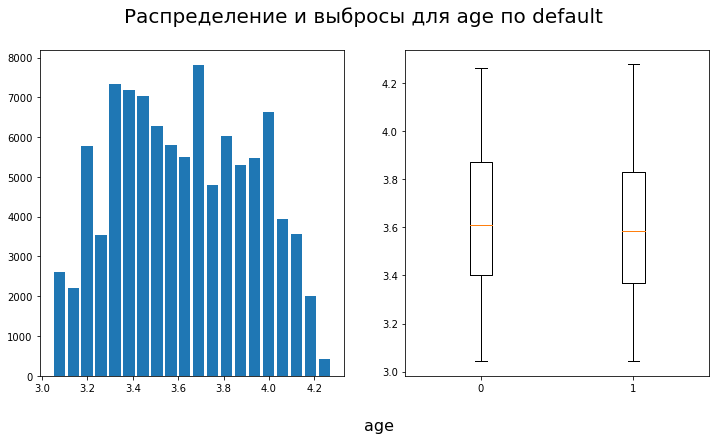

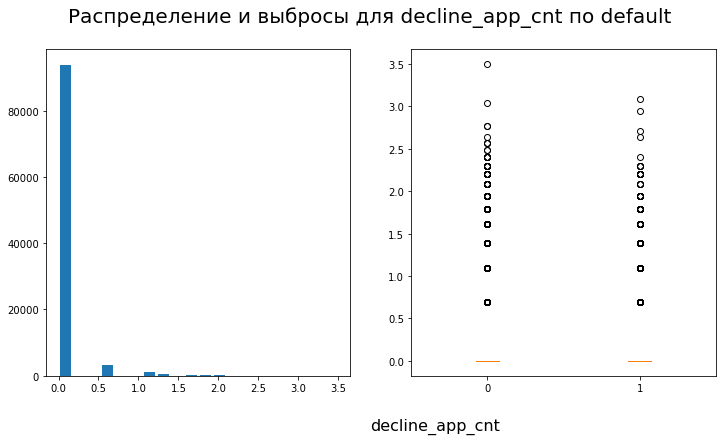

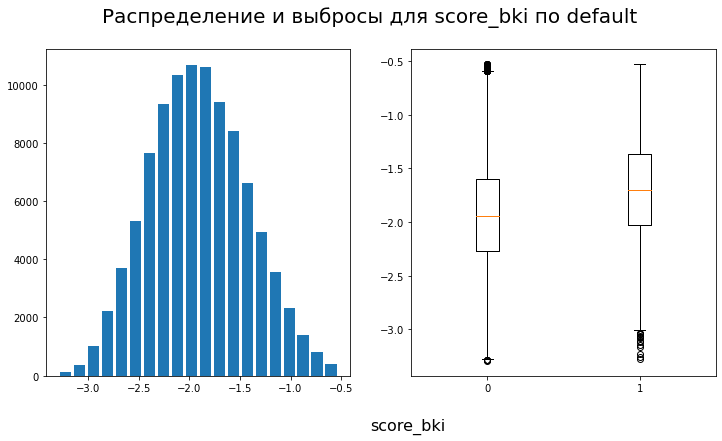

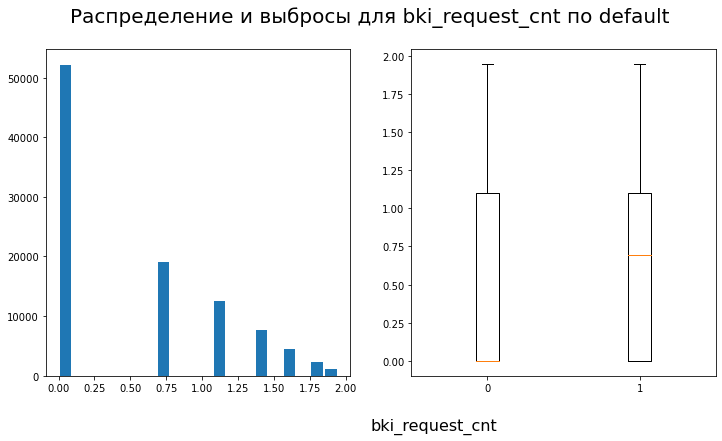

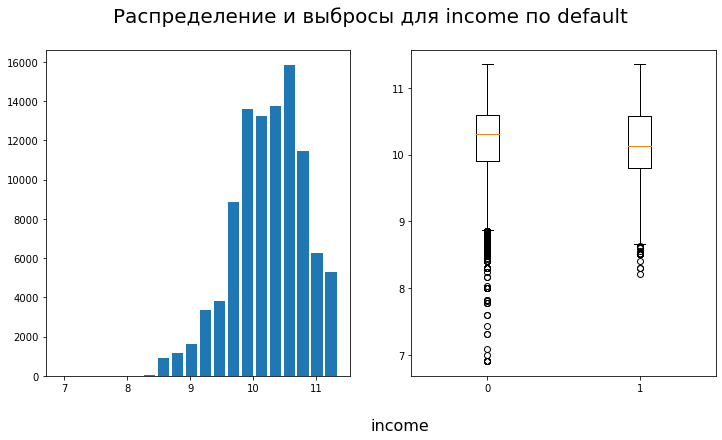

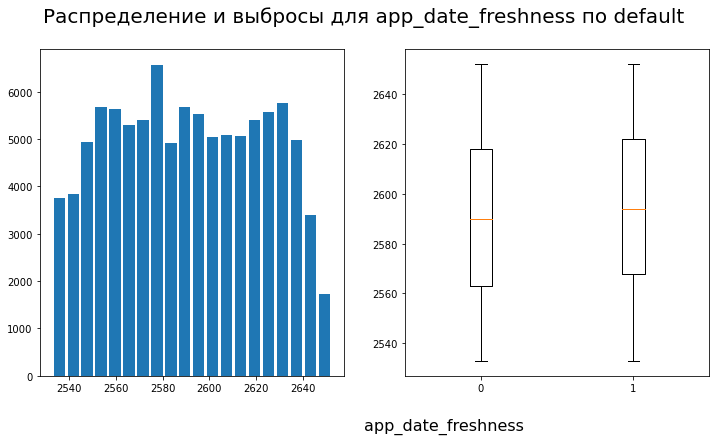

In [31]:
for col in num_cols:
    visual_num(df, col)

 Логарифмирование делает данные более равномерными.

### 2.2. Бинарные признаки

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

In [32]:
# Для бинарных признаков будем использовать LabelEncoder
label_encoder = LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    
# Убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_date_freshness
0,74835,GRD,1,3.367296,1,1,0.000000,0,-2.271884,1.098612,50,1,2,10.819778,1,4,0,0,0,2572
1,17527,SCH,0,3.663562,0,0,1.609438,0,-1.504999,0.693147,50,1,2,8.517193,4,3,0,0,0,2629
2,75683,UGR,1,3.912023,1,1,0.000000,0,-1.691339,0.000000,50,1,2,10.308953,1,3,1,0,0,2571
3,26883,SCH,1,4.025352,0,0,0.000000,0,-2.374182,0.000000,40,1,2,9.740969,1,3,0,0,0,2619
5,99881,SCH,0,4.007333,0,0,0.000000,0,-1.740224,1.945910,50,3,3,10.308953,2,1,0,0,0,2546


### 2.3. Категориальные признаки

Для кодирования категориальных признаков можно воспользоваться One-Hot Encoding transformation. Но для сокращения действий применим get_dummies. 

In [33]:
df = pd.get_dummies(df, columns=cat_cols)

In [34]:
# Новый список категориальных признаков
cat_cols_dummies = [c1 for c in cat_cols for c1 in df.columns if c1.startswith(c)]
cat_cols_dummies

['education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80']

### 2.4. Целевая переменная

In [35]:
df['default'].value_counts(normalize=True, dropna=False)

0    0.914642
1    0.085358
Name: default, dtype: float64

Видно, что недефолтных клиентов значительно больше - распределение неравномерное. Применим метод oversamping - кратно увеличим default-ных копированием.

In [36]:
coeff = int(df[df.default == 0].default.shape[0]/df[df.default == 1].default.shape[0])

In [37]:
df1 = df[df.default == 1]
for _ in range(coeff):
    df = df.append(df1).reset_index(drop=True)

In [38]:
# Проверка
df['default'].value_counts(normalize=True, dropna=False)

1    0.506554
0    0.493446
Name: default, dtype: float64

## 3. Анализ чувствительности и зависимости


### 3.1. Оценка важности признаков

<AxesSubplot:>

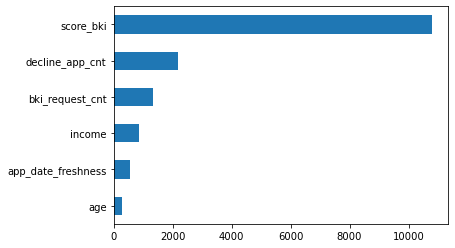

In [39]:
# Числовые признаки
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

<AxesSubplot:>

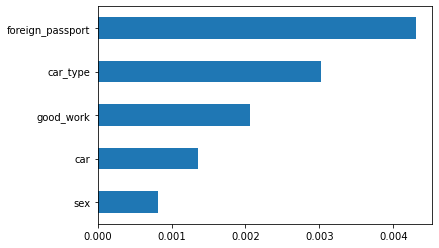

In [40]:
# Бинарные признаки
imp_cat = Series(mutual_info_classif(df[bin_cols], df['default'],
                                     discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

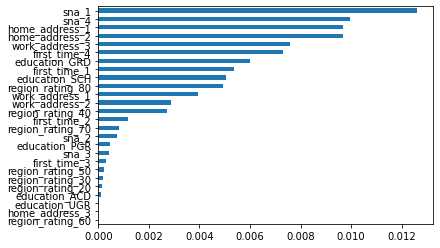

In [41]:
# Категориальные признаки
imp_cat = Series(mutual_info_classif(df[cat_cols_dummies], df['default'],
                                     discrete_features=True), index=cat_cols_dummies)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind='barh')

### 3.2. Корреляционный анализ

,age,decline_app_cnt,score_bki,bki_request_cnt,income,app_date_freshness
age,1.000000,0.123063,0.107624,0.053037,0.155314,0.023127
decline_app_cnt,0.123063,1.000000,0.157337,0.060322,0.001816,0.014613
score_bki,0.107624,0.157337,1.000000,0.110195,0.000718,0.056008
bki_request_cnt,0.053037,0.060322,0.110195,1.000000,0.066533,0.005980
income,0.155314,0.001816,0.000718,0.066533,1.000000,0.005617
app_date_freshness,0.023127,0.014613,0.056008,0.005980,0.005617,1.000000


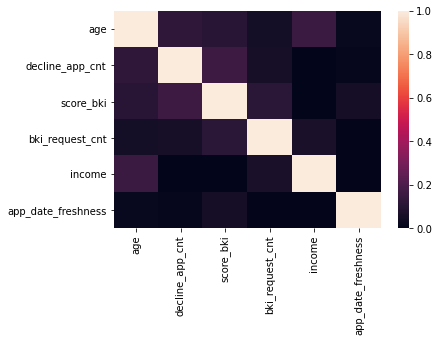

In [42]:
# Посчитаем матрицу корреляции числовых признаков
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)
df[num_cols].corr().abs()

Судя по полученным коэффициентам корреляции между рассматриваемыми признаками нет сильной линейной зависимости.

## 4. Подготовка данных к обучению

In [43]:
# Сгенерируем полиномиальные признаки из числовых
poly = PolynomialFeatures(2)
X_num_poly = poly.fit_transform(df[num_cols].values)
num_cols_poly = poly.get_feature_names(df[num_cols].columns)

Логарифм является частным случаем нормализации - он убирает хвосты.
В дополнение применим масштабирование или стандартизацию.

In [44]:
X_num = StandardScaler().fit_transform(X_num_poly)

In [45]:
df = df.drop(num_cols, axis=1)

In [46]:
# Запишем новые данные в датафрейм
df_final = pd.concat([df, pd.DataFrame(X_num, columns=num_cols_poly)], axis=1)

In [47]:
# Обработанный датасет
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184016 entries, 0 to 184015
Data columns (total 62 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   client_id                           184016 non-null  int64  
 1   sex                                 184016 non-null  int32  
 2   car                                 184016 non-null  int32  
 3   car_type                            184016 non-null  int32  
 4   good_work                           184016 non-null  int64  
 5   foreign_passport                    184016 non-null  int32  
 6   sample                              184016 non-null  int64  
 7   default                             184016 non-null  int64  
 8   education_ACD                       184016 non-null  uint8  
 9   education_GRD                       184016 non-null  uint8  
 10  education_PGR                       184016 non-null  uint8  
 11  education_SCH             

In [48]:
# Теперь выделим тестовую часть kaggle
train_data = df_final.query('sample == 1').drop(['sample'], axis=1)
test_data = df_final.query('sample == 0').drop(['sample'], axis=1)

In [49]:
# Удалим признак, которые не участвует в обучении модели и сохраним его в отдельный список
client_id_list = list(test_data['client_id'])
train_data = train_data.drop('client_id', axis=1)
test_data = test_data.drop('client_id', axis=1)

In [50]:
# Делим на входы/выходы обучающую выборку
y = train_data['default'].values            
X = train_data.drop(['default'], axis=1)

In [51]:
# Удаляем из тестовых данных kaggle целевую переменную
test_data = test_data.drop(['default'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [52]:
# Воспользуемся функцией train_test_split - выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

In [53]:
# База с метриками
summary = pd.DataFrame(index=metrics)

## 5. Обучение модели

In [54]:
# Создаём модель 
model = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)

In [55]:
# Обучаем модель
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [56]:
# Используем обученную модель для предсказания
probs = model.predict_proba(X_test)
y_pred_probs = probs[:,1]
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

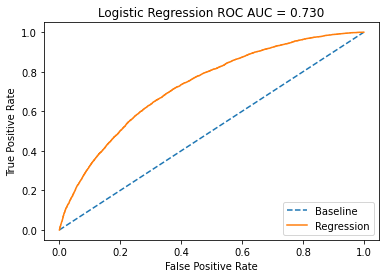

In [57]:
roc_auc_curve(y_test, y_pred_probs)

In [58]:
summary_metrics(summary, 'model_1', y_test, y_pred, y_pred_probs, y_train, y_pred_train)

,model_1
accuracy,0.692692
precision,0.712983
recall,0.841066
f1_train,0.771350
f1_test,0.771746
ROC_AUC,0.729714


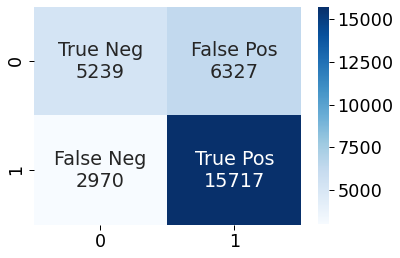

In [59]:
conf_mat(y_test, y_pred)

Подбор гиперпарметров (регуляризация).

In [60]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1291.5496650148827


Применяем найденные гиперпараметры.

In [61]:
model = LogisticRegression(random_state=RANDOM_SEED, penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1291.5496650148827, max_iter=1000, random_state=42)

In [62]:
probs = model.predict_proba(X_test)
y_pred_probs = probs[:,1]
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

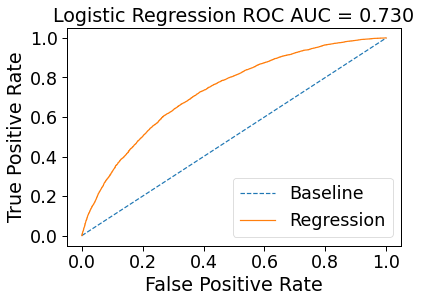

In [63]:
roc_auc_curve(y_test, y_pred_probs)

In [64]:
summary_metrics(summary, 'model_2', y_test, y_pred, y_pred_probs, y_train, y_pred_train)

,model_1,model_2
accuracy,0.692692,0.693154
precision,0.712983,0.712914
recall,0.841066,0.842511
f1_train,0.771350,0.771760
f1_test,0.771746,0.772314
ROC_AUC,0.729714,0.730190


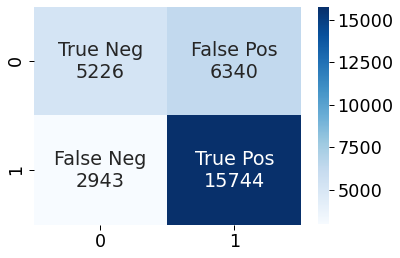

In [65]:
conf_mat(y_test, y_pred)

## 6. Submission


Делаем предсказания модели на тестовых данных kaggle.

In [69]:
probs = model.predict_proba(test_data)
y_pred_probs = probs[:, 1]

In [67]:
my_submission = pd.DataFrame({'client_id': client_id_list, 'default': y_pred_probs})
my_submission.to_csv('submission.csv', index=False)
my_submission.head(10)

,client_id,default
0,74835,0.302802
1,17527,0.869625
2,75683,0.430835
3,26883,0.513315
4,99881,0.691211
5,26630,0.863324
6,79934,0.268485
7,16605,0.189662
8,105449,0.171355
9,49000,0.620563


In [68]:
my_submission.shape

(32751, 2)